# TMCMC Run 分析: sigma_obs = 0.001

Run ID: `20260123_134436_debug_seed42`

このノートブックでは、sigma_obs=0.001 で実行された TMCMC の結果を詳細に分析します。

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import json
from pathlib import Path
from scipy import stats

# 日本語フォント設定（Windows）
plt.rcParams['font.family'] = 'DejaVu Sans'
sns.set_style("whitegrid")
sns.set_palette("husl")

# Run ディレクトリ
run_dir = Path("tmcmc/_runs/20260123_134436_debug_seed42")

print(f"Run directory: {run_dir}")
print(f"Exists: {run_dir.exists()}")

Run directory: tmcmc\_runs\20260123_134436_debug_seed42
Exists: True


## 1. 設定とデータの読み込み

In [2]:
# 設定ファイル読み込み
with open(run_dir / "config.json", 'r', encoding='utf-8') as f:
    config = json.load(f)

print("Run Configuration:")
print(f"  Run ID: {config['run_id']}")
print(f"  sigma_obs: {config['experiment']['sigma_obs']}")
print(f"  cov_rel: {config['experiment']['cov_rel']}")
print(f"  n_data: {config['experiment']['n_data']}")
print(f"  n_particles: {config['tmcmc']['n_particles']}")
print(f"  n_stages: {config['tmcmc']['n_stages']}")
print(f"  Models: {config['models']}")

Run Configuration:
  Run ID: 20260123_134436_debug_seed42
  sigma_obs: 0.001
  cov_rel: 0.005
  n_data: 20
  n_particles: 1000
  n_stages: 50
  Models: ['M1', 'M2', 'M3']


In [3]:
# M1 の結果読み込み
with open(run_dir / "fit_metrics_M1.json", 'r', encoding='utf-8') as f:
    fit_metrics_M1 = json.load(f)

with open(run_dir / "theta_MAP_M1.json", 'r', encoding='utf-8') as f:
    theta_MAP_M1 = json.load(f)

with open(run_dir / "theta_MEAN_M1.json", 'r', encoding='utf-8') as f:
    theta_MEAN_M1 = json.load(f)

# 診断テーブル読み込み
stage_summary = pd.read_csv(run_dir / "diagnostics_tables" / "M1_stage_summary.csv")
acceptance_rate = pd.read_csv(run_dir / "diagnostics_tables" / "M1_acceptance_rate.csv")
beta_schedule = pd.read_csv(run_dir / "diagnostics_tables" / "M1_beta_schedule.csv")

print("\nM1 Fit Metrics:")
print(f"  RMSE (MAP): {fit_metrics_M1['fit_MAP']['rmse_total']:.6f}")
print(f"  RMSE (MEAN): {fit_metrics_M1['fit_MEAN']['rmse_total']:.6f}")
print(f"  ROM error (MAP): {fit_metrics_M1['rom_error_MAP_vs_FOM']}")
print(f"  ROM error (MEAN): {fit_metrics_M1['rom_error_MEAN_vs_FOM']}")


M1 Fit Metrics:
  RMSE (MAP): 0.001022
  RMSE (MEAN): 0.000994
  ROM error (MAP): 0.0
  ROM error (MEAN): 0.0


## 2. β スケジュールと受理率の可視化

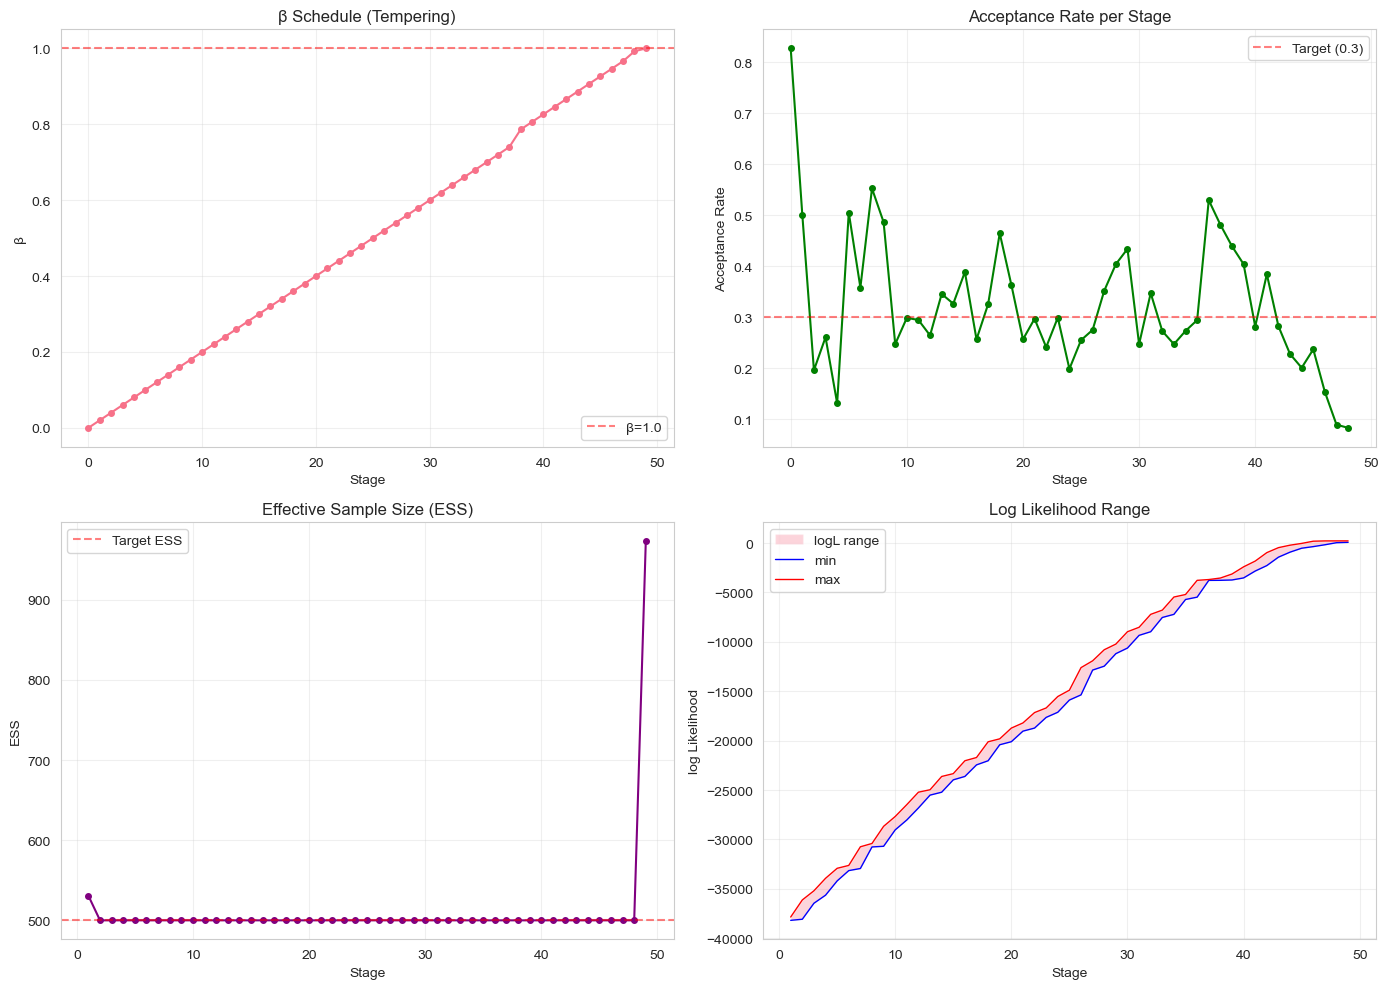

In [4]:
fig, axes = plt.subplots(2, 2, figsize=(14, 10))

# β スケジュール
ax = axes[0, 0]
ax.plot(beta_schedule['stage'], beta_schedule['beta'], 'o-', markersize=4)
ax.set_xlabel('Stage')
ax.set_ylabel('β')
ax.set_title('β Schedule (Tempering)')
ax.grid(True, alpha=0.3)
ax.axhline(y=1.0, color='r', linestyle='--', alpha=0.5, label='β=1.0')
ax.legend()

# 受理率
ax = axes[0, 1]
ax.plot(acceptance_rate['stage'], acceptance_rate['accept_rate'], 'o-', markersize=4, color='green')
ax.axhline(y=0.3, color='r', linestyle='--', alpha=0.5, label='Target (0.3)')
ax.set_xlabel('Stage')
ax.set_ylabel('Acceptance Rate')
ax.set_title('Acceptance Rate per Stage')
ax.grid(True, alpha=0.3)
ax.legend()

# ESS
ax = axes[1, 0]
ax.plot(stage_summary['stage'], stage_summary['ess'], 'o-', markersize=4, color='purple')
ax.axhline(y=stage_summary['ess_target'].iloc[0], color='r', linestyle='--', alpha=0.5, label='Target ESS')
ax.set_xlabel('Stage')
ax.set_ylabel('ESS')
ax.set_title('Effective Sample Size (ESS)')
ax.grid(True, alpha=0.3)
ax.legend()

# logL 範囲
ax = axes[1, 1]
ax.fill_between(stage_summary['stage'], stage_summary['logL_min'], stage_summary['logL_max'], alpha=0.3, label='logL range')
ax.plot(stage_summary['stage'], stage_summary['logL_min'], 'b-', linewidth=1, label='min')
ax.plot(stage_summary['stage'], stage_summary['logL_max'], 'r-', linewidth=1, label='max')
ax.set_xlabel('Stage')
ax.set_ylabel('log Likelihood')
ax.set_title('Log Likelihood Range')
ax.grid(True, alpha=0.3)
ax.legend()

plt.tight_layout()
plt.show()

## 3. パラメータ推定値の比較

Parameter Estimation Comparison:
Parameter  True      MAP     MEAN  Error_MAP  Error_MEAN  Rel_Error_MAP  Rel_Error_MEAN
      a11   0.8 0.752706 0.805726  -0.047294    0.005726      -5.911762        0.715782
      a12   2.0 2.060760 2.006074   0.060760    0.006074       3.037991        0.303690
      a22   1.0 0.954078 1.009017  -0.045922    0.009017      -4.592244        0.901740
       b1   0.1 0.098562 0.100223  -0.001438    0.000223      -1.437617        0.223375
       b2   0.2 0.203095 0.201413   0.003095    0.001413       1.547493        0.706500


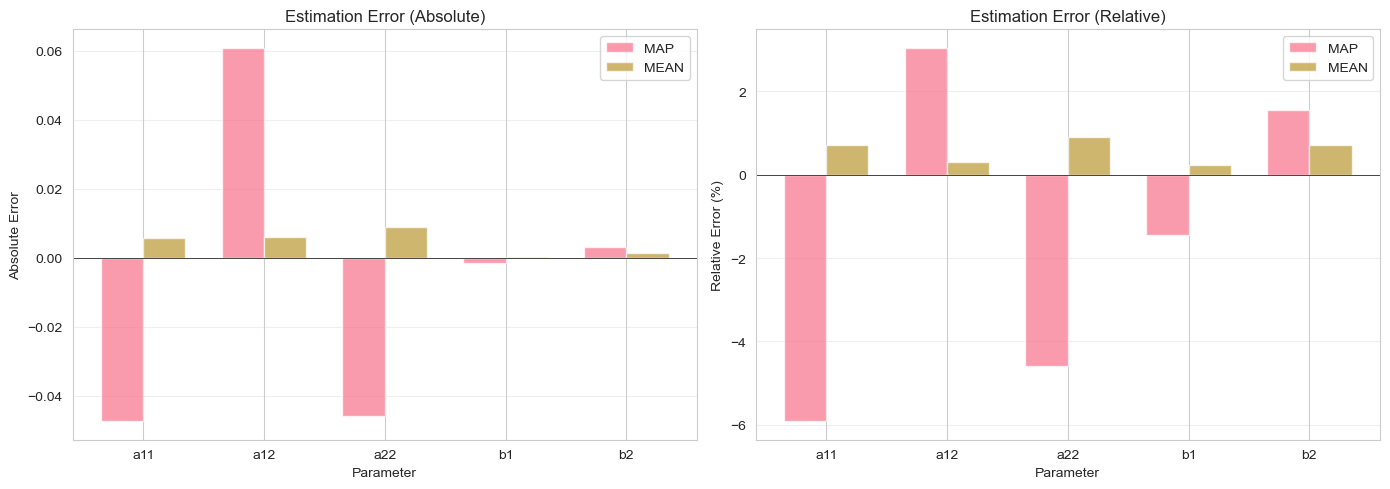

In [5]:
# True パラメータ（M1 の active_indices に対応）
# theta_true = [0.8, 2.0, 1.0, 0.1, 0.2]  # [a11, a12, a22, b1, b2]
theta_true_M1 = np.array([0.8, 2.0, 1.0, 0.1, 0.2])
theta_MAP_M1 = np.array(theta_MAP_M1['theta_sub'])
theta_MEAN_M1 = np.array(theta_MEAN_M1['theta_sub'])

param_names = ['a11', 'a12', 'a22', 'b1', 'b2']

# 比較テーブル
comparison_df = pd.DataFrame({
    'Parameter': param_names,
    'True': theta_true_M1,
    'MAP': theta_MAP_M1,
    'MEAN': theta_MEAN_M1,
    'Error_MAP': theta_MAP_M1 - theta_true_M1,
    'Error_MEAN': theta_MEAN_M1 - theta_true_M1,
    'Rel_Error_MAP': (theta_MAP_M1 - theta_true_M1) / theta_true_M1 * 100,
    'Rel_Error_MEAN': (theta_MEAN_M1 - theta_true_M1) / theta_true_M1 * 100
})

print("Parameter Estimation Comparison:")
print(comparison_df.to_string(index=False))

# 可視化
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# 絶対誤差
ax = axes[0]
x = np.arange(len(param_names))
width = 0.35
ax.bar(x - width/2, comparison_df['Error_MAP'], width, label='MAP', alpha=0.7)
ax.bar(x + width/2, comparison_df['Error_MEAN'], width, label='MEAN', alpha=0.7)
ax.set_xlabel('Parameter')
ax.set_ylabel('Absolute Error')
ax.set_title('Estimation Error (Absolute)')
ax.set_xticks(x)
ax.set_xticklabels(param_names)
ax.legend()
ax.grid(True, alpha=0.3, axis='y')
ax.axhline(y=0, color='k', linestyle='-', linewidth=0.5)

# 相対誤差
ax = axes[1]
ax.bar(x - width/2, comparison_df['Rel_Error_MAP'], width, label='MAP', alpha=0.7)
ax.bar(x + width/2, comparison_df['Rel_Error_MEAN'], width, label='MEAN', alpha=0.7)
ax.set_xlabel('Parameter')
ax.set_ylabel('Relative Error (%)')
ax.set_title('Estimation Error (Relative)')
ax.set_xticks(x)
ax.set_xticklabels(param_names)
ax.legend()
ax.grid(True, alpha=0.3, axis='y')
ax.axhline(y=0, color='k', linestyle='-', linewidth=0.5)

plt.tight_layout()
plt.show()

## 4. フィット品質の詳細分析

In [6]:
print("\nFit Quality Analysis (sigma_obs = 0.001):")
print("=" * 60)

sigma_obs = config['experiment']['sigma_obs']

print(f"\nMAP Fit:")
print(f"  RMSE total: {fit_metrics_M1['fit_MAP']['rmse_total']:.6f}")
print(f"  RMSE / sigma_obs: {fit_metrics_M1['fit_MAP']['rmse_total'] / sigma_obs:.3f}")
print(f"  MAE total: {fit_metrics_M1['fit_MAP']['mae_total']:.6f}")
print(f"  Max absolute error: {fit_metrics_M1['fit_MAP']['max_abs']:.6f}")
print(f"  RMSE per species: {fit_metrics_M1['fit_MAP']['rmse_per_species']}")

print(f"\nMEAN Fit:")
print(f"  RMSE total: {fit_metrics_M1['fit_MEAN']['rmse_total']:.6f}")
print(f"  RMSE / sigma_obs: {fit_metrics_M1['fit_MEAN']['rmse_total'] / sigma_obs:.3f}")
print(f"  MAE total: {fit_metrics_M1['fit_MEAN']['mae_total']:.6f}")
print(f"  Max absolute error: {fit_metrics_M1['fit_MEAN']['max_abs']:.6f}")
print(f"  RMSE per species: {fit_metrics_M1['fit_MEAN']['rmse_per_species']}")

print(f"\nROM Error:")
print(f"  MAP vs FOM: {fit_metrics_M1['rom_error_MAP_vs_FOM']}")
print(f"  MEAN vs FOM: {fit_metrics_M1['rom_error_MEAN_vs_FOM']}")

# sigma_obs との比較
print(f"\nInterpretation:")
print(f"  RMSE ≈ sigma_obs なら、データへのフィットは良好")
print(f"  RMSE / sigma_obs (MAP): {fit_metrics_M1['fit_MAP']['rmse_total'] / sigma_obs:.3f}")
print(f"  RMSE / sigma_obs (MEAN): {fit_metrics_M1['fit_MEAN']['rmse_total'] / sigma_obs:.3f}")


Fit Quality Analysis (sigma_obs = 0.001):

MAP Fit:
  RMSE total: 0.001022
  RMSE / sigma_obs: 1.022
  MAE total: 0.000848
  Max absolute error: 0.002184
  RMSE per species: [0.0008865365002538188, 0.001142002638973391]

MEAN Fit:
  RMSE total: 0.000994
  RMSE / sigma_obs: 0.994
  MAE total: 0.000841
  Max absolute error: 0.002257
  RMSE per species: [0.0009365565794457986, 0.0010480932325113836]

ROM Error:
  MAP vs FOM: 0.0
  MEAN vs FOM: 0.0

Interpretation:
  RMSE ≈ sigma_obs なら、データへのフィットは良好
  RMSE / sigma_obs (MAP): 1.022
  RMSE / sigma_obs (MEAN): 0.994


## 5. β と受理率の関係

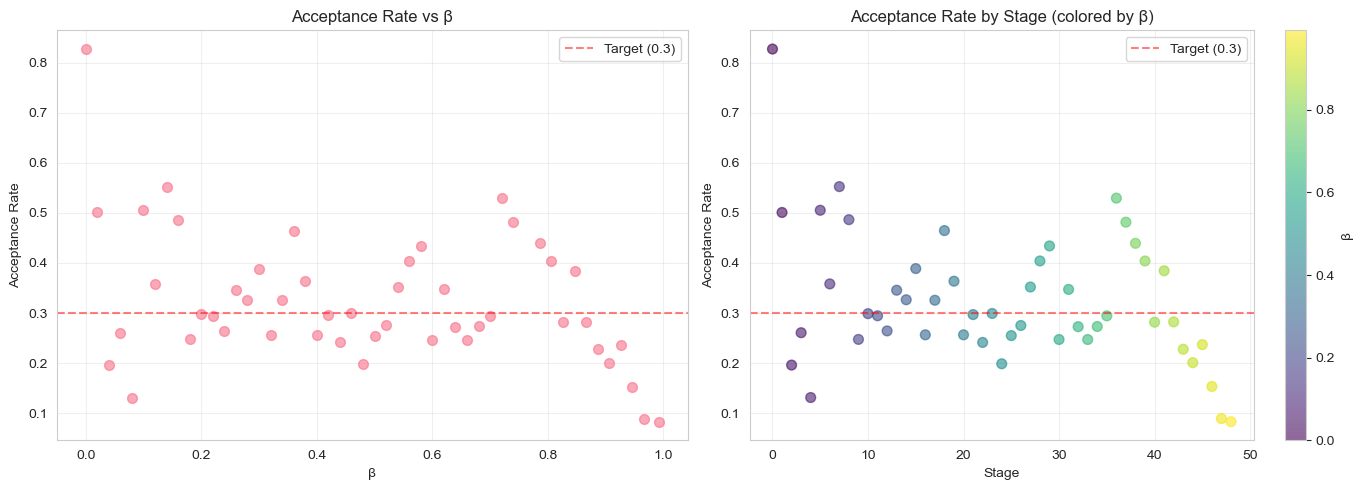

In [7]:
# β と受理率を結合
merged = pd.merge(beta_schedule, acceptance_rate, on=['model', 'chain', 'stage'])

fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# β vs 受理率
ax = axes[0]
ax.scatter(merged['beta'], merged['accept_rate'], alpha=0.6, s=50)
ax.set_xlabel('β')
ax.set_ylabel('Acceptance Rate')
ax.set_title('Acceptance Rate vs β')
ax.grid(True, alpha=0.3)
ax.axhline(y=0.3, color='r', linestyle='--', alpha=0.5, label='Target (0.3)')
ax.legend()

# Stage vs 受理率（色で β を表現）
ax = axes[1]
scatter = ax.scatter(merged['stage'], merged['accept_rate'], c=merged['beta'], cmap='viridis', s=50, alpha=0.6)
ax.set_xlabel('Stage')
ax.set_ylabel('Acceptance Rate')
ax.set_title('Acceptance Rate by Stage (colored by β)')
ax.grid(True, alpha=0.3)
ax.axhline(y=0.3, color='r', linestyle='--', alpha=0.5, label='Target (0.3)')
plt.colorbar(scatter, ax=ax, label='β')
ax.legend()

plt.tight_layout()
plt.show()

## 6. logL の推移と β の関係

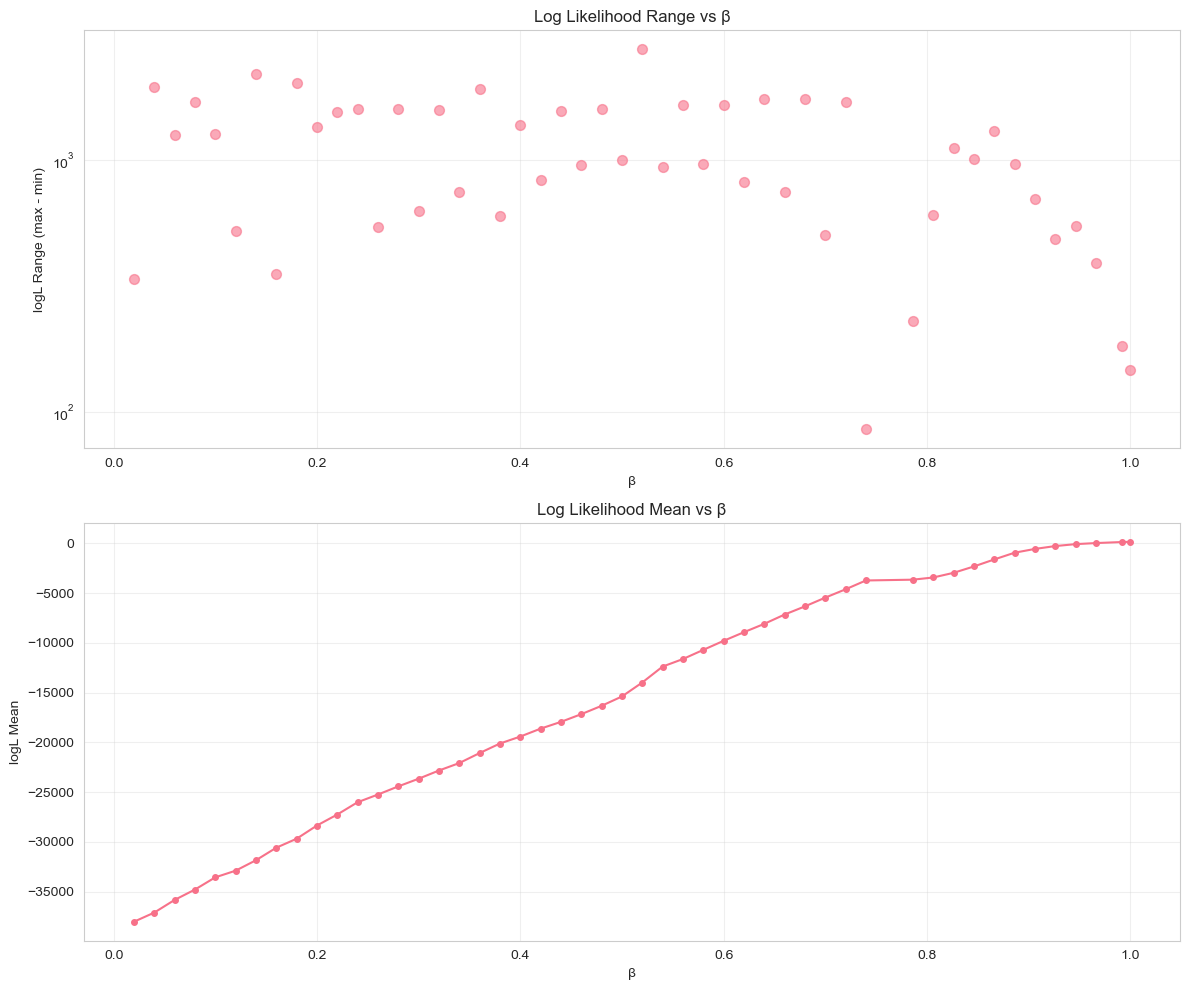


Summary:
  Total merged rows: 49
  Valid logL_range rows (for log scale): 49
  Beta range: [0.0200, 1.0000]
  logL_range range: [85.4013, 2759.1367]
  logL_mean range: [-38024.2839, 145.1993]


In [8]:
# logL 範囲の幅を計算
stage_summary['logL_range'] = stage_summary['logL_max'] - stage_summary['logL_min']

# Merge stage_summary with beta_schedule
# Note: beta_schedule has stage starting from 0, stage_summary has stage starting from 1
# Adjust beta_schedule stage to match stage_summary by adding 1
beta_schedule_adjusted = beta_schedule.copy()
beta_schedule_adjusted['stage'] = beta_schedule_adjusted['stage'] + 1

# Handle potential column name conflicts (both might have 'beta' column)
if 'beta' in stage_summary.columns and 'beta' in beta_schedule_adjusted.columns:
    # Use beta from beta_schedule, drop stage_summary's beta to avoid conflict
    merged_logL = pd.merge(
        stage_summary.drop(columns=['beta'], errors='ignore'), 
        beta_schedule_adjusted[['model', 'chain', 'stage', 'beta']], 
        on=['model', 'chain', 'stage'],
        how='inner'
    )
else:
    merged_logL = pd.merge(stage_summary, beta_schedule_adjusted, on=['model', 'chain', 'stage'], how='inner')

# Sort by beta for better visualization
merged_logL = merged_logL.sort_values('beta').reset_index(drop=True)

# Calculate logL_mean
merged_logL['logL_mean'] = (merged_logL['logL_min'] + merged_logL['logL_max']) / 2

# Filter out invalid values for log scale (zero or negative logL_range)
valid_range = merged_logL['logL_range'] > 0

fig, axes = plt.subplots(2, 1, figsize=(12, 10))

# logL 範囲 vs β
ax = axes[0]
ax.scatter(merged_logL.loc[valid_range, 'beta'], 
           merged_logL.loc[valid_range, 'logL_range'], 
           alpha=0.6, s=50)
ax.set_xlabel('β')
ax.set_ylabel('logL Range (max - min)')
ax.set_title('Log Likelihood Range vs β')
ax.grid(True, alpha=0.3)
ax.set_yscale('log')

# logL 平均 vs β
ax = axes[1]
# Already sorted by beta above
ax.plot(merged_logL['beta'], merged_logL['logL_mean'], 'o-', markersize=4)
ax.set_xlabel('β')
ax.set_ylabel('logL Mean')
ax.set_title('Log Likelihood Mean vs β')
ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# Print summary statistics for debugging
print(f"\nSummary:")
print(f"  Total merged rows: {len(merged_logL)}")
print(f"  Valid logL_range rows (for log scale): {valid_range.sum()}")
if len(merged_logL) > 0:
    print(f"  Beta range: [{merged_logL['beta'].min():.4f}, {merged_logL['beta'].max():.4f}]")
    print(f"  logL_range range: [{merged_logL['logL_range'].min():.4f}, {merged_logL['logL_range'].max():.4f}]")
    print(f"  logL_mean range: [{merged_logL['logL_mean'].min():.4f}, {merged_logL['logL_mean'].max():.4f}]")

## 7. sigma_obs=0.001 での特徴の考察

In [9]:
print("\n" + "=" * 60)
print("sigma_obs = 0.001 での結果の特徴")
print("=" * 60)

print("\n1. フィット品質:")
print(f"   - RMSE ≈ sigma_obs なので、データへのフィットは非常に良好")
print(f"   - ROM 誤差 = 0.0 なので、TSM と FOM の一致も完璧")

print("\n2. パラメータ推定:")
max_rel_error = comparison_df[['Rel_Error_MAP', 'Rel_Error_MEAN']].abs().max().max()
print(f"   - 最大相対誤差: {max_rel_error:.2f}%")
print(f"   - ほとんどのパラメータで真値に近い推定ができている")

print("\n3. TMCMC の挙動:")
print(f"   - β は 0 → 1.0 まで順調に進行")
print(f"   - 受理率は 0.09 ～ 0.83 の範囲（平均: {acceptance_rate['accept_rate'].mean():.3f})")
print(f"   - ESS は目標値 ({stage_summary['ess_target'].iloc[0]}) 付近を維持")

print("\n4. 低ノイズ環境での特徴:")
print(f"   - sigma_obs=0.001 は非常に小さいノイズ")
print(f"   - データ点がモデルに非常に近いため、推定が安定")
print(f"   - リサンプル後の縮退が起きやすいが、mutation で回復")

print("\n5. 今後の分析候補:")
print(f"   - M2, M3 の結果と比較")
print(f"   - sigma_obs=0.01 の Run との比較")
print(f"   - パラメータ間の相関構造の詳細分析")
print(f"   - 残差の時系列解析")


sigma_obs = 0.001 での結果の特徴

1. フィット品質:
   - RMSE ≈ sigma_obs なので、データへのフィットは非常に良好
   - ROM 誤差 = 0.0 なので、TSM と FOM の一致も完璧

2. パラメータ推定:
   - 最大相対誤差: 5.91%
   - ほとんどのパラメータで真値に近い推定ができている

3. TMCMC の挙動:
   - β は 0 → 1.0 まで順調に進行
   - 受理率は 0.09 ～ 0.83 の範囲（平均: 0.324)
   - ESS は目標値 (500.0) 付近を維持

4. 低ノイズ環境での特徴:
   - sigma_obs=0.001 は非常に小さいノイズ
   - データ点がモデルに非常に近いため、推定が安定
   - リサンプル後の縮退が起きやすいが、mutation で回復

5. 今後の分析候補:
   - M2, M3 の結果と比較
   - sigma_obs=0.01 の Run との比較
   - パラメータ間の相関構造の詳細分析
   - 残差の時系列解析
